In [1]:
### INITIALIZING AND DATA GATHERING ###


import pandas
import numpy
pandas.set_option('display.max_columns',500)
pandas.set_option('display.max_rows',700)
pandas.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import requests
import json
from pandas.io.json import json_normalize
from numpy.random import choice
from collections import Counter, defaultdict

# ------------------ uncomment the section below to refresh time series actuals data ------------------------

# #Tiingo: equity and forex info https://api.tiingo.com/documentation/end-of-day
# headers = {
#     'Content-Type': 'application/json'
# }

# #Equity data
# start = '2018-01-01'
# end = '2020-12-31'
# agg = 'daily' #daily, weekly, monthly, annually
# responses = pandas.DataFrame(columns = ['date','close','high','low','open','volume','adjClose','adjHigh','adjLow','adjOpen','adjVolume','divCash','splitFactor','name'])
# ticker_list =['LYFT','CCL','MTCH','GRUB','DIS','TSLA','NLY','FNKO','HPE','ACB','KHC','LEVI','PYPL','IAU','GBTC','RSP','BLL','LTC','DDOG','FANG','GE','WWE']

# for ticker in ticker_list:
#     r = requests.get('https://api.tiingo.com/tiingo/daily/'+ticker+'/prices?startDate='+start+'&endDate='+end+'&resampleFreq='+agg+'&token=b5d11c96514c4d7974e4179d5131a933690f2b60', headers=headers)
#     j = r.json()
#     df = pandas.DataFrame(json_normalize(j))
#     df['name'] = ticker
#     responses = pandas.concat([responses, df], axis=0)

# responses['date'] = pandas.to_datetime(responses['date']).apply(lambda x: x.date())
# responses.to_csv('stock_time_series.csv')

# -----------------------------------------------------------------------------------------------------


data = pandas.read_csv('stock_time_series.csv')
data = data.drop(['Unnamed: 0','close','high','low','volume','open','adjHigh','adjLow','splitFactor'],axis=1)
data['date'] = pandas.to_datetime(data['date'])
data = data.set_index('date')

data['MA5'] = data.groupby('name')['adjClose'].transform(lambda x: x.rolling(5, 1).mean())
data['MA7'] = data.groupby('name')['adjClose'].transform(lambda x: x.rolling(7, 1).mean())
data['MA10'] = data.groupby('name')['adjClose'].transform(lambda x: x.rolling(10, 1).mean())

data['Vol5'] = data.groupby('name')['adjVolume'].transform(lambda x: x.rolling(5, 1).mean())
data['Vol7'] = data.groupby('name')['adjVolume'].transform(lambda x: x.rolling(7, 1).mean())
data['Vol10'] = data.groupby('name')['adjVolume'].transform(lambda x: x.rolling(10, 1).mean())

data['future_close_1_day'] = data.groupby('name')['adjClose'].shift(-1)
data['future_close_5_day'] = data.groupby('name')['adjClose'].shift(-5)
data['future_close_7_day'] = data.groupby('name')['adjClose'].shift(-7)
data['future_close_10_day'] = data.groupby('name')['adjClose'].shift(-10)

data['past_close_1_day'] = data.groupby('name')['adjClose'].shift(1)
data['past_close_5_day'] = data.groupby('name')['adjClose'].shift(5)
data['past_close_7_day'] = data.groupby('name')['adjClose'].shift(7)
data['past_close_10_day'] = data.groupby('name')['adjClose'].shift(10)

data['return_1_day'] = data['adjClose']/data['past_close_1_day']-1
data['return_5_day'] = data['adjClose']/data['past_close_5_day']-1
data['return_7_day'] = data['adjClose']/data['past_close_7_day']-1
data['return_10_day'] = data['adjClose']/data['past_close_10_day']-1

names = data['name'].unique().tolist()

In [39]:
### FUTURE PREDICTION BASED ON HISTORICAL DAILY RETURN WEIGHTS ###

def historical_preds(future_days,trials_needed,initial_price):
    stock_rounded = [round(i,3)*100 for i in stock]
    c = Counter( stock_rounded )
    return_combo = [(i, c[i] / len(stock_rounded) * 100.0) for i, count in c.most_common()]
    returns = [sublist[0] for sublist in return_combo]
    weights = [sublist[1] for sublist in return_combo]
    weights = numpy.array(weights)
    weights /= weights.sum()
    days_out = future_days
    trials_to_run = trials_needed
    trial = 1
    sim_all = pandas.DataFrame()

    for num in range(trials_to_run):

        initial_close = initial_price
        last_close = initial_close
        historical_sim = []
        day = 0
        historical_sim.insert(0,initial_close)
        historical_sim.insert(1,day)
        for i in range(days_out):
            draw = choice(returns,1,p=weights)
            new_price = (1+(draw/100.0))*last_close
            last_close = new_price[0]
            day += 1
            historical_sim.append(new_price[0])
            historical_sim.append(day)
        sim_results = historical_sim[::2]
        sim_days = historical_sim[1::2]
        sim_df = pandas.DataFrame(
            {'day': sim_days,
             'prediction': sim_results
            })
        sim_final = sim_df.set_index('day')
        sim_final['trial'] = trial
        trial += 1
        sim_all = pandas.concat([sim_all,sim_final],axis=0)
    return sim_all

Mean of simulations for percent return: -0.010466181103782583
Best percent return simulation: 2.7004153195980107
Worst percent return simulation: -0.9071261621615536
% of simulations that were profitable: 0.428
Predictions are the black dotted lines
Actuals are the green lines


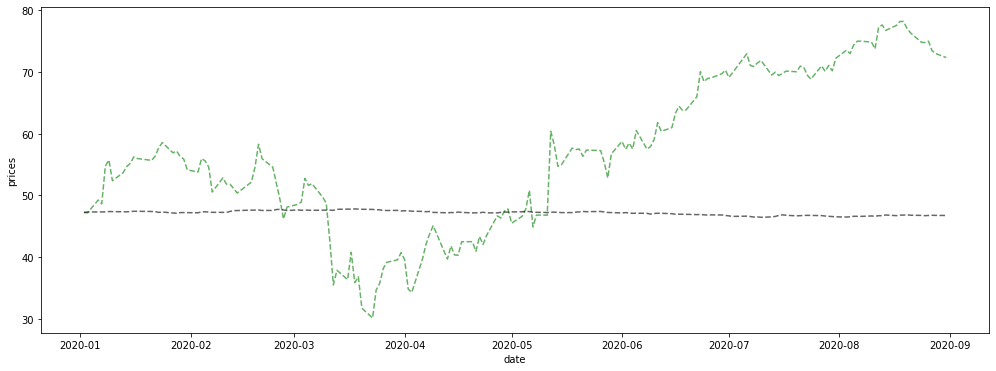

In [70]:
### BACK TESTING AGAINST ACTUAL RESULTS ###

# user input needed here ------------------------------
symbol = 'GRUB'
start_date = '2020-01-01'
end_date = '2020-08-31'
#------------------------------------------------------

stock = data[numpy.logical_and(data['name']==symbol,data.index<start_date)]['return_1_day'].dropna().tolist()
actuals = pandas.DataFrame(data[numpy.logical_and(data['name']==symbol,numpy.logical_and(data.index<=end_date,data.index>=start_date))]['adjClose'])
init = data[numpy.logical_and(data['name']==symbol,numpy.logical_and(data.index<=end_date,data.index>=start_date))]['adjClose'].iloc[0]
days = data[numpy.logical_and(data['name']==symbol,numpy.logical_and(data.index<=end_date,data.index>=start_date))]['adjClose'].count()-1
test = historical_preds(future_days=days,trials_needed=1000,initial_price=init)

print('Mean of simulations for percent return: '+str((test[test.index==days]['prediction']/init-1).mean()))
print('Best percent return simulation: '+str((test[test.index==days]['prediction']/init-1).max()))
print('Worst percent return simulation: '+str((test[test.index==days]['prediction']/init-1).min()))
print('% of simulations that were profitable: '+str((test[test.index==days]['prediction']>init-1).sum()/1000))

test_outcome = pandas.DataFrame(test['prediction'].groupby('day').mean())
combo = pandas.concat([actuals, test_outcome.set_index(actuals.index)], axis=1)
combo['diff'] = combo['prediction']-combo['adjClose']
combo['pct'] = combo['prediction']/combo['adjClose']-1

fig, ax1 = plt.subplots(figsize=(17,6))
ax1.set_xlabel('date')
ax1.set_ylabel('prices')
ax1.plot(combo.index, combo['adjClose'],linestyle='--',alpha=.6, color='green')
ax1.plot(combo.index, combo['prediction'],linestyle='--',alpha=.6, color='black')
ax1.tick_params(axis='y')
print('Predictions are the black dotted lines')
print('Actuals are the green lines')
plt.show()

In [ ]:
# Ignore below for now, these are other prediction models I am testing out but not ready yet

In [ ]:
### PREDICTION MODEL FOR 5 DAYS OUT ###

model_data_train = data[numpy.logical_and(data['name']=='DIS',data.index.to_series().between('2020-05-01','2020-12-31'))]
model_data_train = model_data_train.dropna()

y_model = model_data_train.future_close_5_day
X_model = model_data_train.drop(['name','future_close_1_day','future_close_5_day','future_close_7_day','future_close_10_day'],axis=1).astype('float64')
alphas = 10**numpy.linspace(10,-2,100)*0.5
X_train, X_test , y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)

ridgereg = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgereg.fit(X_train, y_train)
ridge_preds = ridgereg.predict(X_test)

lasso = Lasso(max_iter = 10000, normalize = True)
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

print('Lasso intercept: '+ str(lasso.intercept_))
print('Lasso coefs:')
print(pandas.Series(lasso.coef_, index=X_model.columns).sort_values(ascending=False))
print('Lasso MSE: ' + str(mean_squared_error(y_test, lasso_preds)))

print('Ridge intercept: '+ str(ridgereg.intercept_))
print('Ridge coefs:')
print(pandas.Series(ridgereg.coef_, index = X_model.columns).sort_values(ascending=False))
print('Ridge MSE: ' + str(mean_squared_error(y_test, ridge_preds)))


In [249]:
### COMPARISON OF PREDICTORS ###

lasso_preds_all = lasso.predict(X_model)
ridge_preds_all = ridgereg.predict(X_model)
model_data_train2 = model_data_train
model_data_train2['lasso_preds'] = lasso_preds_all
model_data_train2['ridge_preds'] = ridge_preds_all
model_data_train2['lasso_pred_diff'] = model_data_train2['future_close_5_day']-model_data_train2['lasso_preds']
model_data_train2['lasso_pred_perc'] = model_data_train2['future_close_5_day']/model_data_train2['lasso_preds']-1
model_data_train2['ridge_pred_diff'] = model_data_train2['future_close_5_day']-model_data_train2['ridge_preds']
model_data_train2['ridge_pred_perc'] = model_data_train2['future_close_5_day']/model_data_train2['ridge_preds']-1
model_data_train2['lasso_threshold_2_perc'] = numpy.where(abs(model_data_train2['lasso_pred_perc']) <= .02 ,1,0)
model_data_train2['ridge_threshold_2_perc'] = numpy.where(abs(model_data_train2['ridge_pred_perc']) <= .02 ,1,0)
model_data_train2[['lasso_threshold_2_perc','ridge_threshold_2_perc']].sum()/model_data_train2[['lasso_threshold_2_perc','ridge_threshold_2_perc']].count()

lasso_threshold_2_perc    0.376812
ridge_threshold_2_perc    0.333333
dtype: float64

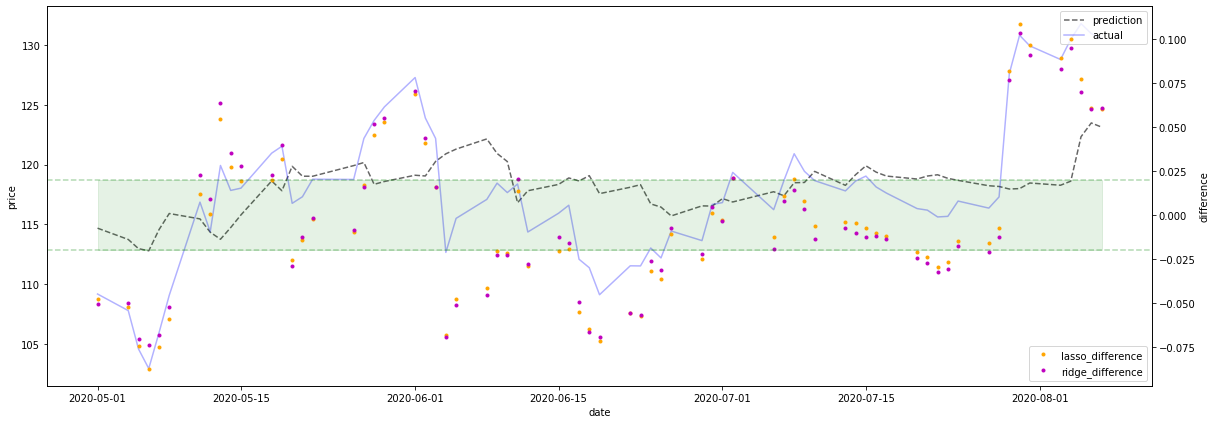

In [250]:
### PLOT OF PREDICTIONS VS ACTUALS WITH ACCEPTABLE TOLERANCE LEVEL ###

fig, ax1 = plt.subplots(figsize=(17,6))


color = 'black'
ax1.set_xlabel('date')
ax1.set_ylabel('price')
ax1.plot(model_data_train2.index, model_data_train2['lasso_preds'],linestyle='--',alpha=.6, color=color)
ax1.tick_params(axis='y')

color = 'blue'
ax1.plot(model_data_train2.index, model_data_train2['future_close_5_day'], color=color,alpha=.3)
ax1.tick_params(axis='y')

ax1.legend(['prediction', 'actual'], loc='upper right')

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('difference')
ax2.plot(model_data_train2.index, model_data_train2['lasso_pred_perc'],markersize=3 ,color=color,linestyle='' ,marker='o')
ax2.tick_params(axis='y')

color = 'm'
ax2.plot(model_data_train2.index, model_data_train2['ridge_pred_perc'],markersize=3 ,color=color,linestyle='' ,marker='o')
ax2.tick_params(axis='y')

ax2.legend(['lasso_difference','ridge_difference'],loc='lower right')

fig.tight_layout()
ax2.fill_between(model_data_train2.index,-.02,.02,color='green',alpha=.1)
ax2.axhline(.02,color='green',alpha=.3,linestyle='--')
ax2.axhline(-.02,color='green',alpha=.3,linestyle='--')
plt.show()

In [339]:
### SIMULATION FOR DAILY BUYING LOW ###
#have not figured out the running profit yet

sim = model_data_train2
sim['buy'] = numpy.where(sim['adjClose'] < sim['lasso_preds'],1,0)
sim['sell_day_value'] = sim['adjClose'].shift(-5)
sim['profit_perc'] = numpy.where(sim['buy']==1,sim['sell_day_value']/sim['adjClose']-1,0)
sim['cost'] = numpy.where(sim['buy']==1,sim['adjClose'],0)
sim['profit'] = numpy.where(sim['buy']==1,sim['sell_day_value']-sim['adjClose'],0)
sim['no_logic_profit'] = sim['sell_day_value']-sim['adjClose']
sim['cashout'] = numpy.where(sim['buy'].shift(5)==0,0,sim['sell_day_value'].shift(5).fillna(0))
sim['shares'] = numpy.select([numpy.logical_and(sim['buy']==1,sim['cashout']==0),numpy.logical_and(sim['buy']==0,sim['cashout']>0)],[1,-1],0).cumsum()
sim['value'] = sim['adjClose']*sim['shares']

print(sim['cost'].sum())
print(sim['profit'].sum())
print(sim['no_logic_profit'].sum())

6261.39
154.27
105.81
